In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

torch.manual_seed(0)
np.random.seed(0)
pd.set_option("display.max_columns", None)

In [2]:
# Technical indicators
trend_indicators = ["DMN_5", "DMN_10", "ADX_5", "ADX_10", "DMP_5"]
oscillators =["MACD_8_21_5", "STOCHd_7_3_3", "RSI_7"]
moving_averages = ["MA_20", "KAMA_3_2_10", "EMA_15", "MA_10"]
volatility_indicators = ["Bollinger_Lower", "Bollinger_Upper"]
other_indicators = []
technical_indicators = (
    trend_indicators + oscillators + moving_averages + volatility_indicators + other_indicators
)

# LOB specific indicators
mid_price_indicators = ["std_mid_price", "weighted_mid_price_variation", "mean_mid_price_variation"]
bid_ask_prices_indicators = ["std_spread", "mean_spread"]
volume_indicators = ["total_bid_volume", "total_ask_volume", "std_best_bid_size", "std_best_ask_size"]
orders_indicators = ["mean_order_book_imbalance", "order_book_imbalance_5s", "order_flow_5s", "last_order_book_imbalance", "total_net_order_flow"]
lob_indicators = mid_price_indicators + bid_ask_prices_indicators + volume_indicators + orders_indicators

time_indicators = ['time_since_open']

# Feature list
features =  lob_indicators + time_indicators

In [ ]:
# Parameters
sampling_rate = "2s"
prediction_column = "mean_mid_price_variation_class"
batch_size = 32
look_back = 18

In [4]:
raw_data = pd.read_parquet("all_data.parquet")

start_date = "2024-11-12"
end_date = "2024-11-22"

all_data = raw_data.loc[start_date:end_date]

all_data.head()

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,next_5_mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-12 09:30:56-05:00,224.785,224.805,224.810,224.78,224.799216,0.008167,224.770229,224.813847,224.806498,0.03,0.032353,0.007200,224.79,224.783039,224.82,224.815392,500.0,312.029412,168.601437,129.0,97.362745,59.262428,224.825392,224.766765,0.000089,2.0,0.000063,1,0,0.000194,1,1302.0,-860.0,0.525169,0.589825,371,51.0,48.0,3,0.279496,122.2,499.0,-1.0,0.0,0.0,224.79,224.78,224.79,224.78,36.547409,23.671776,18.612781,8.739074,16.814400,33.906705,27.074417,0.000000,100.000000,0.005,0.005,0.005,0.050,0.155,0.200,12.195122,17.398374,-0.022486,32.574620,-0.04425,224.879177,224.896541,224.849152,224.925860,224.873715,-0.043333,-0.03250,-0.036,-0.020000,225.033854,224.713577,0.320277,0.085736,0.020,-0.100,-0.050,0.000,0.030,0.005,56.0,0,1,0,0,0
2024-11-12 09:30:58-05:00,224.800,224.715,224.820,224.71,224.759497,0.034559,224.806667,224.720455,224.755324,0.03,0.043707,0.021191,224.70,224.737643,224.73,224.781350,525.0,310.395881,652.073275,245.0,195.707094,123.131657,224.793753,224.726201,-0.000378,0.0,-0.000180,0,0,-0.000383,0,276.0,2285.0,0.227226,0.363636,280,197.0,186.0,54,0.299181,164.2,25.0,116.0,0.0,0.0,224.79,224.70,224.82,224.70,43.865684,28.102459,20.339484,6.462118,14.821267,41.652736,31.408370,14.285714,100.000000,0.090,0.090,0.090,0.090,0.090,0.155,1.818182,4.671101,-0.026627,27.935664,-0.06150,224.864217,224.866293,224.809305,224.904123,224.871600,-0.055000,-0.05375,-0.043,-0.044167,225.036529,224.706671,0.329858,0.090111,-0.085,0.020,-0.100,-0.050,0.110,0.025,58.0,0,1,0,0,0
2024-11-12 09:31:00-05:00,224.715,224.755,224.760,224.68,224.714722,0.020407,224.720455,224.739459,224.710894,0.05,0.056587,0.026246,224.73,224.686429,224.78,224.743016,35.0,112.984127,69.847388,150.0,172.023810,100.169337,224.755185,224.672751,0.000178,2.0,-0.000001,0,0,0.000085,1,789.0,-1599.0,-0.210520,-0.621622,-115,168.0,179.0,31,0.185197,131.6,-490.0,-95.0,0.0,0.0,224.70,224.78,224.78,224.69,50.557505,32.600474,22.355809,5.224604,13.525674,40.857475,31.940866,0.000000,100.000000,0.035,0.035,0.035,0.035,0.105,0.225,24.590164,12.867823,-0.029879,23.528908,-0.07575,224.845530,224.831857,224.767268,224.874737,224.867705,-0.008333,-0.03125,-0.035,-0.029167,225.043248,224.692161,0.351087,0.093927,0.040,-0.085,0.020,-0.100,0.080,0.020,60.0,0,1,0,0,0
2024-11-12 09:31:02-05:00,224.755,224.710,224.770,224.70,224.725805,0.020679,224.739459,224.698750,224.719302,0.06,0.052979,0.016320,224.68,224.699315,224.74,224.752295,25.0,104.698630,109.257247,55.0,137.660959,79.497681,224.765000,224.682877,-0.000200,0.0,-0.000130,0,0,-0.000181,0,-753.0,289.0,-0.

In [5]:
all_data[prediction_column].value_counts()

mean_mid_price_variation_class
0    44968
1    37775
Name: count, dtype: int64

In [ ]:
train_size = int(len(all_data) * 0.5)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size : train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size :, :]

In [7]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

class ScaledTimeSeriesDataset(Dataset):
    def __init__(self, data, target, features, look_back):
        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.features = features
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        sequence = self.data[idx : idx + self.look_back]
        target = self.targets[idx + self.look_back]

        # Apply scaling for each training example
        scaler = MinMaxScaler(feature_range=(0, 1))
        sequence = scaler.fit_transform(sequence)

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
            target, dtype=torch.long
        )


In [8]:
# Create datasets
train_dataset = ScaledTimeSeriesDataset(train_df, prediction_column, features, look_back)
val_dataset = ScaledTimeSeriesDataset(val_df, prediction_column, features, look_back)
test_dataset = ScaledTimeSeriesDataset(test_df, prediction_column, features, look_back)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the PyTorch model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)  # Reshape for BatchNorm
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :] 
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x
    

class LSTMModelWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModelWithAttention, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        
        # Attention layer
        self.attention = nn.Linear(hidden_size1, 1) 
        
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # First LSTM layer
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1) 
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        
        # Attention mechanism
        attention_scores = self.attention(x) 
        attention_scores = nn.functional.softmax(attention_scores, dim=1) 
        x = x * attention_scores
        x = x.sum(dim=1)
        
        # Second LSTM layer
        x = x.unsqueeze(1) 
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [10]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_size = len(features)
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(all_data[prediction_column]))

model = LSTMModel(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=None):

    model.to(device) 
    print(f"Model is on device: {next(model.parameters()).device}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted_train == batch_y).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += batch_y.size(0)
                correct_val += (predicted_val == batch_y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

def evaluate_model(model, test_loader, device=None):

    model.eval() 
    all_predictions = []
    true_labels = []
    all_probs = []

    with torch.no_grad(): 
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            probs = torch.softmax(outputs, dim=1) 
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])

    true_labels = np.array(true_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    return true_labels, all_predictions, all_probs

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=8, device=device)

Model is on device: cpu
Epoch 1/8, Train Loss: 0.6847, Train Acc: 0.5565, Val Loss: 0.6783, Val Acc: 0.5759
Epoch 2/8, Train Loss: 0.6801, Train Acc: 0.5658, Val Loss: 0.6744, Val Acc: 0.5735
Epoch 3/8, Train Loss: 0.6804, Train Acc: 0.5667, Val Loss: 0.6733, Val Acc: 0.5795
Epoch 4/8, Train Loss: 0.6793, Train Acc: 0.5661, Val Loss: 0.6760, Val Acc: 0.5746
Epoch 5/8, Train Loss: 0.6794, Train Acc: 0.5673, Val Loss: 0.6769, Val Acc: 0.5696
Epoch 6/8, Train Loss: 0.6792, Train Acc: 0.5703, Val Loss: 0.6728, Val Acc: 0.5835
Epoch 7/8, Train Loss: 0.6789, Train Acc: 0.5708, Val Loss: 0.6728, Val Acc: 0.5827
Epoch 8/8, Train Loss: 0.6782, Train Acc: 0.5702, Val Loss: 0.6740, Val Acc: 0.5746


In [13]:
true_labels, all_predictions, all_probs = evaluate_model(model, test_loader, device)

Accuracy: 0.5684
              precision    recall  f1-score   support

           0       0.58      0.73      0.65     17984
           1       0.54      0.37      0.44     15102

    accuracy                           0.57     33086
   macro avg       0.56      0.55      0.54     33086
weighted avg       0.56      0.57      0.55     33086



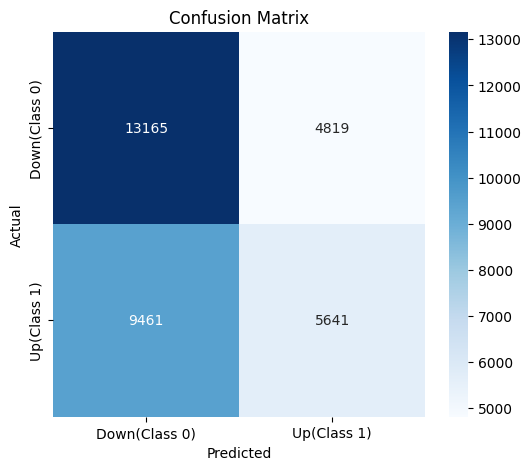

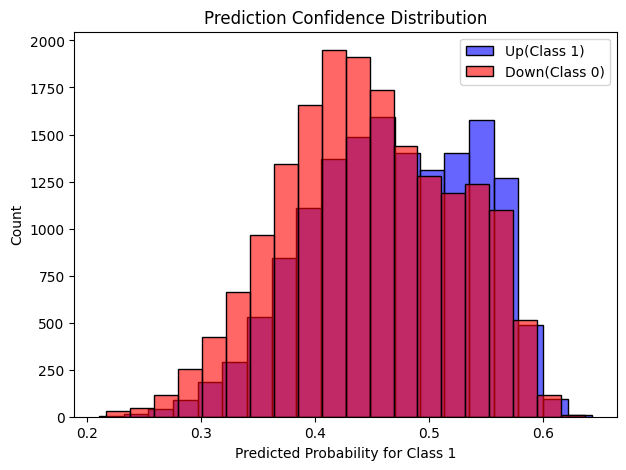

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(true_labels, all_predictions):.4f}")
print(classification_report(true_labels, all_predictions, zero_division=0))

conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(all_probs[true_labels == 1], color="blue", label="Up(Class 1)", bins=20, alpha=0.6)
sns.histplot(all_probs[true_labels == 0], color="red", label="Down(Class 0)", bins=20, alpha=0.6)
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


Backtest Metrics for LSTM Strategy:
Duration: 4 days
Initial Capital: 1000.00, Final Capital: 1106.81
Annualized Return: 59687.60%
Annualized Volatility: 11.21%


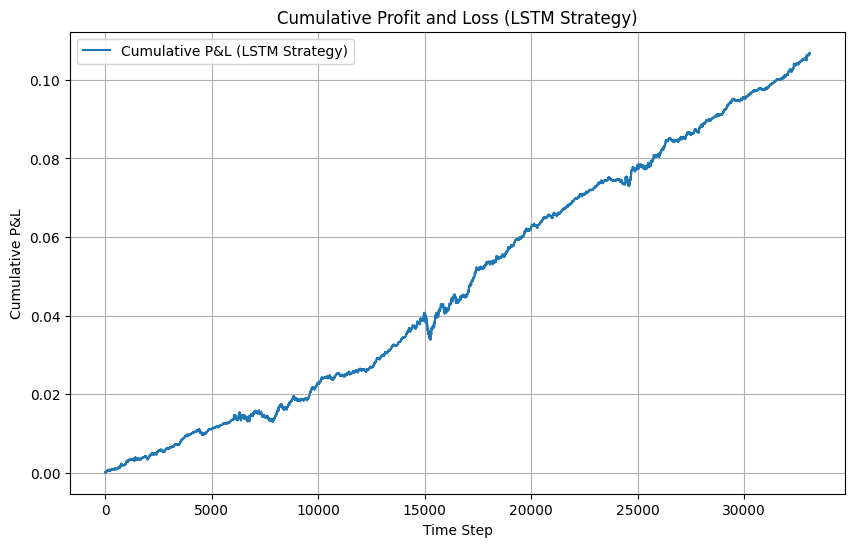

In [ ]:
from finance_utils import plot_backtest_results, backtest_strategy

true_percentage_changes = test_df["mid_price_variation"].iloc[look_back:].values
timestamps = test_df.index[look_back:]

lstm_results = backtest_strategy(
    all_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(lstm_results, "LSTM Strategy")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


y_train = train_df[prediction_column].shift(-1).dropna().astype(int)
y_test = test_df[prediction_column].shift(-1).dropna().astype(int)

X_train = train_df[features].iloc[:-1].values
X_test = test_df[features].iloc[:-1].values

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(solver='saga', max_iter=1000, random_state=0)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='saga')

Test Accuracy (Logistic Regression): 0.5732
              precision    recall  f1-score   support

           0       0.59      0.71      0.64     17990
           1       0.54      0.41      0.47     15107

    accuracy                           0.57     33097
   macro avg       0.57      0.56      0.56     33097
weighted avg       0.57      0.57      0.56     33097



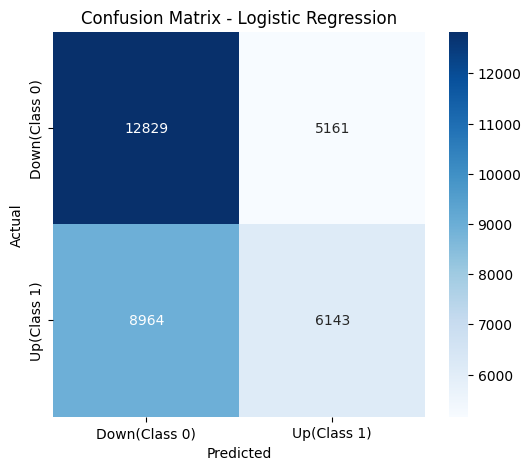

In [ ]:
test_predictions = log_reg.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")
print(classification_report(y_test, test_predictions, zero_division=0))

conf_matrix_log_reg = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Backtest Metrics for Logistic Regression Strategy:
Duration: 4 days
Initial Capital: 1000.00, Final Capital: 1107.96
Annualized Return: 63736.23%
Annualized Volatility: 14.81%


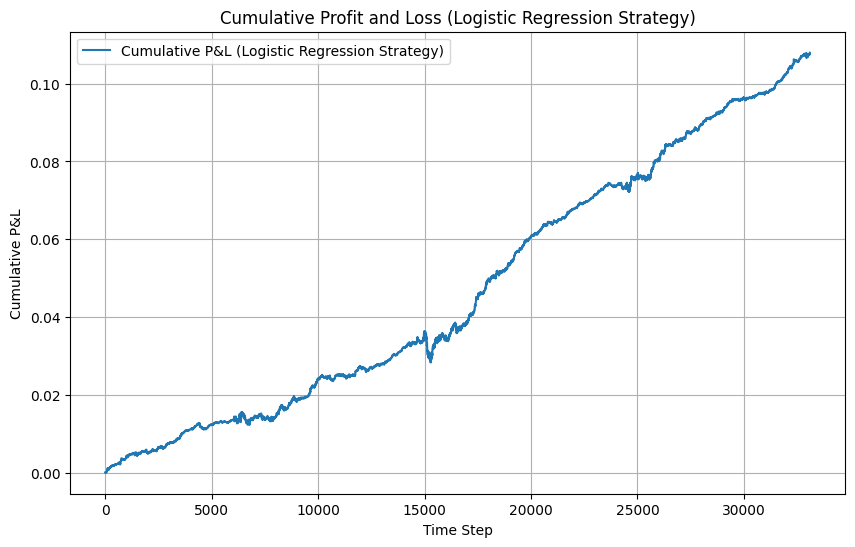

In [ ]:
true_percentage_changes_logistic = test_df["mid_price_variation"].iloc[1:].values
timestamps_logistic = test_df.index[1:]

log_reg_results = backtest_strategy(
    test_predictions, true_percentage_changes_logistic, timestamps_logistic, initial_capital=1000
)
plot_backtest_results(log_reg_results, "Logistic Regression Strategy")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

Test Accuracy (Random Forest Classifier): 0.5583
              precision    recall  f1-score   support

           0       0.58      0.67      0.62     17990
           1       0.52      0.42      0.46     15107

    accuracy                           0.56     33097
   macro avg       0.55      0.55      0.54     33097
weighted avg       0.55      0.56      0.55     33097



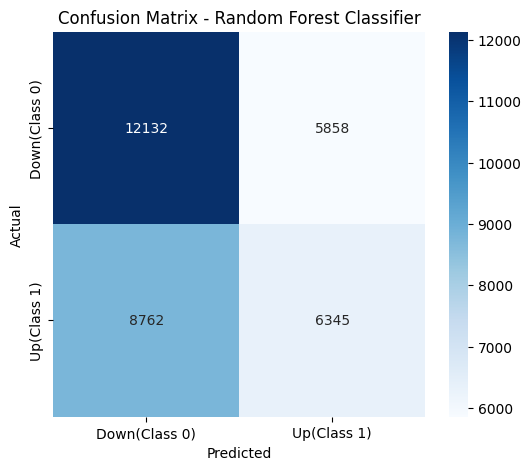

In [ ]:
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Test Accuracy (Random Forest Classifier): {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions, zero_division=0))

conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()


Backtest Metrics for Random Forest Strategy:
Duration: 4 days
Initial Capital: 1000.00, Final Capital: 1084.16
Annualized Return: 16152.41%
Annualized Volatility: 16.34%


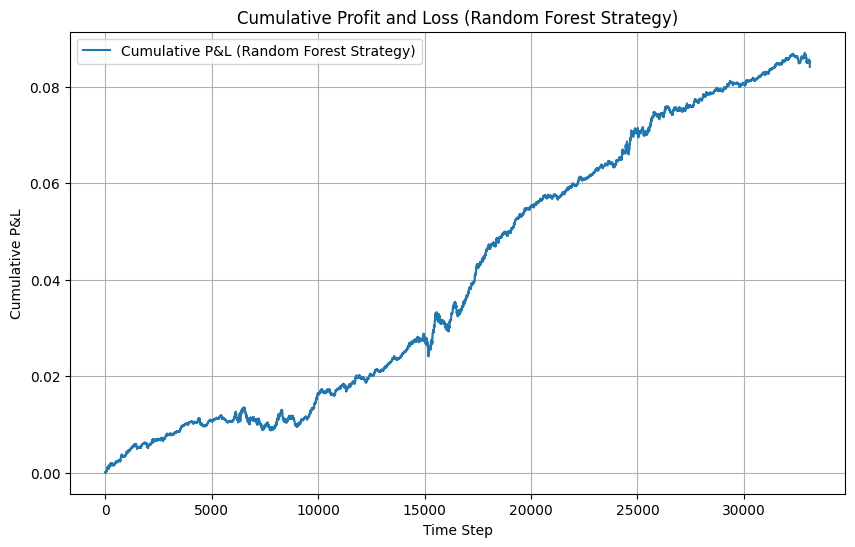

In [ ]:
true_percentage_changes_rf = test_df["mid_price_variation"].iloc[1:].values
timestamps_rf = test_df.index[1:]

rf_results = backtest_strategy(
    rf_predictions, true_percentage_changes_rf, timestamps_rf, initial_capital=1000
)
plot_backtest_results(rf_results, "Random Forest Strategy")

Random Prediction Accuracy: 0.4974
              precision    recall  f1-score   support

           0       0.54      0.50      0.52     17984
           1       0.45      0.50      0.48     15102

    accuracy                           0.50     33086
   macro avg       0.50      0.50      0.50     33086
weighted avg       0.50      0.50      0.50     33086



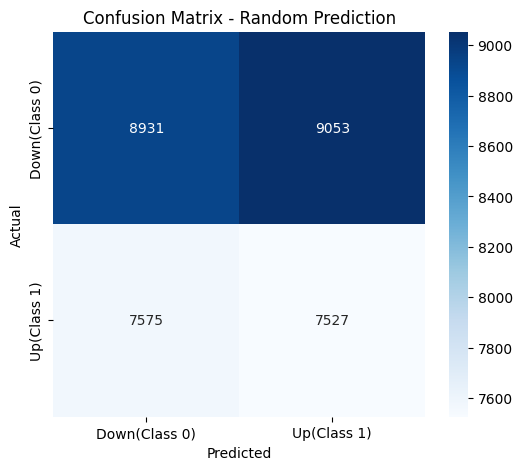

In [ ]:
random_predictions = np.random.randint(0, 2, size=len(true_labels))
print(f"Random Prediction Accuracy: {accuracy_score(true_labels, random_predictions):.4f}")
print(classification_report(true_labels, random_predictions, zero_division=0))

conf_matrix_random = confusion_matrix(true_labels, random_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_random, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Prediction")
plt.show()


Backtest Metrics for Random Strategy:
Duration: 4 days
Initial Capital: 1000.00, Final Capital: 981.16
Annualized Return: -69.82%
Annualized Volatility: 6.04%


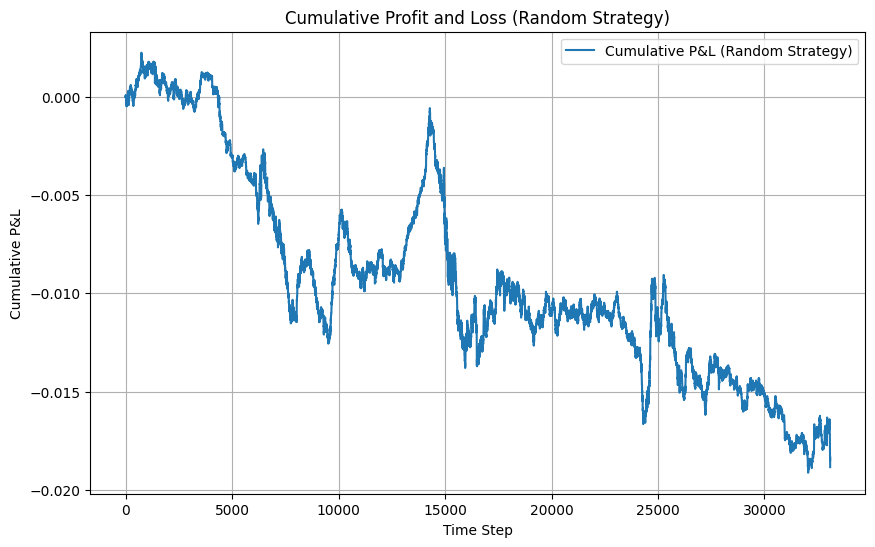

In [24]:
random_results = backtest_strategy(
    random_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(random_results, "Random Strategy")

Most Common Class Prediction Accuracy: 0.5436
              precision    recall  f1-score   support

           0       0.54      1.00      0.70     17984
           1       0.00      0.00      0.00     15102

    accuracy                           0.54     33086
   macro avg       0.27      0.50      0.35     33086
weighted avg       0.30      0.54      0.38     33086



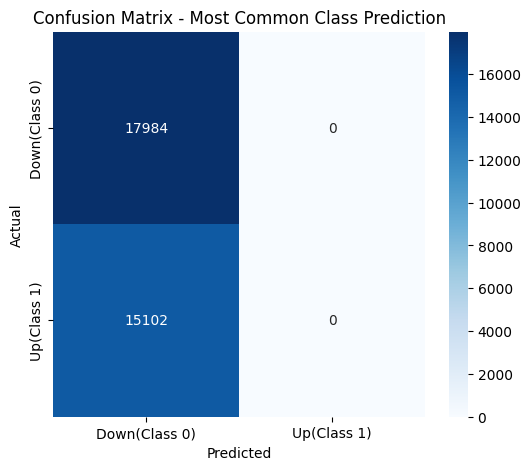

In [25]:
train_labels = []
for _, batch_y in train_loader:
    train_labels.extend(batch_y.cpu().numpy())
train_labels = np.array(train_labels)
most_common_class = np.bincount(train_labels).argmax()
most_common_predictions = np.full_like(true_labels, most_common_class)
print(f"Most Common Class Prediction Accuracy: {accuracy_score(true_labels, most_common_predictions):.4f}")
print(classification_report(true_labels, most_common_predictions, zero_division=0))

conf_matrix_most_common = confusion_matrix(true_labels, most_common_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_most_common, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Most Common Class Prediction")
plt.show()


Backtest Metrics for Most Common Class Strategy:
Duration: 4 days
Initial Capital: 1000.00, Final Capital: 1000.00
Annualized Return: 0.00%
Annualized Volatility: 0.00%


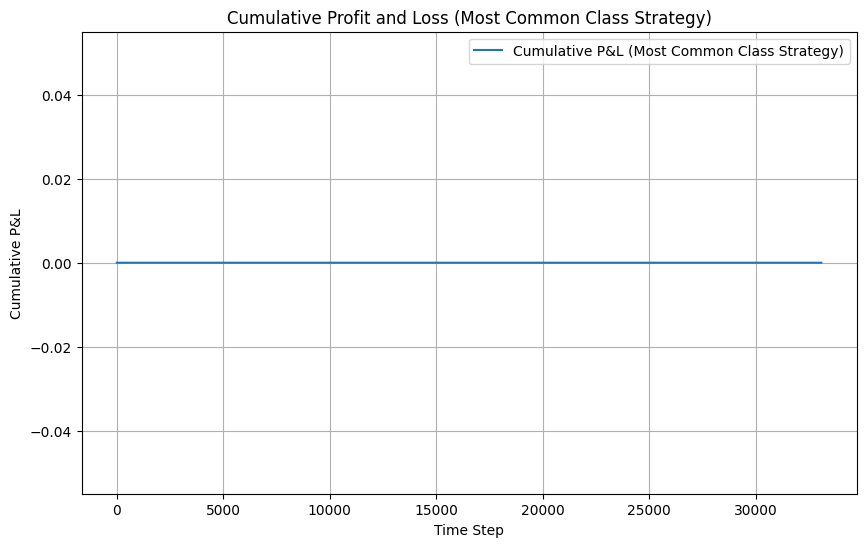

In [26]:
most_common_results = backtest_strategy(
    most_common_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(most_common_results, "Most Common Class Strategy")